#### This is using Keras  
Tutorial comes from here: https://www.tensorflow.org/tutorials/structured_data/time_series

In [1]:
from __future__ import print_function, division
import numpy as np
import pandas as pd
import tensorflow as tf
import json
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

from config import getConfig
import metrics
from preProcessor import preProcess
from plots import plotWind, plotTime, plotDistribution
from identify_seasonality import getFreq
from setPandasOptions import setPandasOptions
from getHighCorr import getHighCorr
from batchGenerator import getBatch

In [2]:
def splitData(df):
    n = len(df)
    trainIdx = int(n*0.7)
    valIdx = int(n*0.9)
    train = df[0:trainIdx]
    val = df[trainIdx:valIdx]
    test = df[valIdx:]
    return train, val, test

In [3]:
def normalize(train, val, test):
    train_mean = train.mean()
    train_std = train.std()
    print("avg: ", train_mean['temp'])
    print("std: ", train_std['temp'])
    
    train = (train - train_mean) / train_std
    val = (val - train_mean) / train_std
    test = (test - train_mean) / train_std
    return train, val, test

In [4]:
def plot(preds, actuals):
    fig, ax = plt.subplots(figsize=(12, 3))
    plt.plot(preds, c='r', label='Prediction')
    plt.plot(actuals, c='g', label='Actuals')
    plt.legend()
    plt.show()

In [5]:
setPandasOptions()
cfg = getConfig()
modelCfg = json.load(open('modelConfig.json', 'r'))

In [6]:
df = pd.read_csv(cfg['dataLoc']+cfg['fileName'])

In [7]:
# Identify highly correlated columns and remove one of them
'''correlatedCols = getHighCorr(df, 0.94)
for cols, coeff in correlatedCols:
    print("{:<20}{:<20}{:<.3f}".format(cols[0], cols[1], coeff))'''

removeCols = ['H2OC (mmol/mol)', 'Tpot (K)', 'sh (g/kg)', 'VPact (mbar)', 'rho (g/m**3)',
              'VPmax (mbar)', 'max. wv (m/s)']
for col in removeCols:
    del df[col]

In [8]:
df = preProcess(df, cfg)

350,460 rows removed due to sampling


In [9]:
#plotWind(df)
#plotTime(df)
#getFreq(df)

In [10]:
train, val, test = splitData(df)
svTrain = train.copy()
train, val, test = normalize(train, val, test)

avg:  9.108195
std:  8.65495


In [11]:
'''correlatedCols = getHighCorr(train, 0.9)
for cols, coeff in correlatedCols:
    print("{:<20}{:<20}{:<.3f}".format(cols[0], cols[1], coeff))'''

'correlatedCols = getHighCorr(train, 0.9)\nfor cols, coeff in correlatedCols:\n    print("{:<20}{:<20}{:<.3f}".format(cols[0], cols[1], coeff))'

In [12]:
#plotDistribution(df, svTrain)

In [20]:
model = tf.keras.models.Sequential()

l1 = tf.keras.layers.LSTM(32, return_sequences=False)
l2 = tf.keras.layers.Dense(units=1)

model.add(l1)
model.add(l2)
# Shape => [batch, time, features]    

model.compile(loss='mean_squared_error', optimizer='adam')

In [21]:
hist = model.fit(getBatch(train, False, 4), batch_size=None, verbose=1)
print(hist.history['loss'])


epoch #  1
  16331/Unknown - 60s 4ms/step - loss: 0.0179
epoch #  2
  32669/Unknown - 120s 4ms/step - loss: 0.0126
epoch #  3
  49012/Unknown - 180s 4ms/step - loss: 0.0107
epoch #  4
65352/65352 [==============================] - 240s 4ms/step - loss: 0.0097
[0.009663344360888004]


In [22]:
pred = model.predict(getBatch(test, True, 1))


epoch #  1


In [23]:
actuals = test['temp'][:-50]

In [24]:
avg=  9.108195
std=  8.65495

pred = pred*std+avg
actuals= actuals*std+avg
actuals=actuals.reset_index(drop=True)

In [25]:
# calcMAPE blows up if any 0 values
actuals[actuals==0]=0.1

rmse = metrics.calcRMSE(actuals, pred)
mape = metrics.calcMAPE(actuals, pred)
print("RMSE is {:.2f}".format(rmse))
print("MAPE is {:.2%}".format(mape))

RMSE is 4.54
MAPE is 77.00%


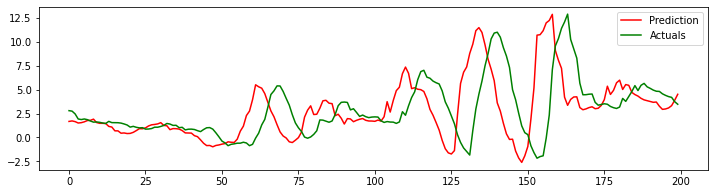

In [26]:
start=0
length=200
plot(pred[start:start+length], actuals[start:start+length])